In [1]:
# 모듈 로딩
import tensorflow as tf
from tensorflow.keras import Sequential      # 모델 객체
from tensorflow.keras.layers import Dense    # 레이어 객체
from tensorflow.keras.datasets.boston_housing import load_data
from keras.layers import Dropout
import numpy as np

In [2]:
# Tensorflow는 (x_train, y_train), (x_test, y_test) => 훈련, 테스트끼리

In [3]:
# 학습용:테스트용 = 8:2
(X_train, y_train), (X_test, y_test) = load_data()

In [4]:
X_train.shape, X_test.shape

((404, 13), (102, 13))

In [5]:
X_train[:1], y_train[0]

(array([[  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
          91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
          18.72   ]]),
 15.2)

### [ 1-1 ] 전처리
---
- 특성(Feature)의 전처리
  * 수치 데이터 : 값의 범위
  * 문자 데이터 : 수치화

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [7]:
scaler.mean_, scaler.scale_

(array([3.74511057e+00, 1.14801980e+01, 1.11044307e+01, 6.18811881e-02,
        5.57355941e-01, 6.26708168e+00, 6.90106436e+01, 3.74027079e+00,
        9.44059406e+00, 4.05898515e+02, 1.84759901e+01, 3.54783168e+02,
        1.27408168e+01]),
 array([9.22929073e+00, 2.37382770e+01, 6.80287253e+00, 2.40939633e-01,
        1.17147847e-01, 7.08908627e-01, 2.79060634e+01, 2.02770050e+00,
        8.68758849e+00, 1.66168506e+02, 2.19765689e+00, 9.39946015e+01,
        7.24556085e+00]))

In [8]:
X_train_scaled = scaler.transform(X_train)

### [2] NN Model 실습
---
- (1) 구상  
- (2) 생성  
- (3) 학습  
- (4) 평가  
- (5) 테스트
---

### [2-1] 구상
---
- 입력 데이터 => 13 feature
- 출력 데이터 => 1 집값

In [9]:
# NN Model의 layer를 층층이 담아서 관리하는 객체
model = Sequential(name='Boston')

In [10]:
# input_shape=(,)를 따로 떼어줘도
# model.add ( Input(shape=(13,), name='input'))

# Layer 추가 하기 (하나만 바로 출력하는 경우 - loss가 너무 큼)
# if) 층 1개 => 즉, 바로 출력
# model.add(Dense(1, activation='linear', input_shape=(13,)))

# 회귀 => layer추가 후, 출력
model.add(Dense(30, activation='relu', input_shape=(13,), name = 'hidden-1'))

# 과적합을 해결하기 위해서 Dropout()  사용
# 지정된 비용만큼 node를 비활성화
# 30개 중 15개는 Drop 시키고 넘김
model.add( Dropout(0.5) )
model.add(Dense(10, activation='relu' , name = 'hidden-2'))

# 회귀 => 출력
model.add(Dense(1, activation='linear', name='output'))

In [11]:
# 모델 구성 확인
model.summary()

Model: "Boston"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden-1 (Dense)            (None, 30)                420       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 hidden-2 (Dense)            (None, 10)                310       
                                                                 
 output (Dense)              (None, 1)                 11        
                                                                 
Total params: 741
Trainable params: 741
Non-trainable params: 0
_________________________________________________________________


### [2-2] 생성
---
- Sequential 클래스의 compile 메서드  
  
- 모델이 동작하기 위해서 필요한 설정
    * 오차 계산 함수 설정       => loss  
    - W, B 최적화 방식 설정     => optimizer  
    - 모델의 성능 측정 항목 설정 => metrics  
    
- 파라미터 값들
    * str 타입으로 입력 가능
    * 객체 타입으로 입력 가능

In [12]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# optimizer에 들어가는 것 여러개 띄워주고자 할 때 => shift + tab으로 적는 방식 보기

### [2-3] 학습
---
- fit() 메서드
    * 파라미터
    * 반환값 -> History 객체

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
# 검증 데이터에 대한 loss값 3번 연속 개선되지 않으면 학습 중지
stopCB = EarlyStopping(monitor='val_loss', patience=3)

# 많이 돌리더라도 원하는 수치에 도달하지 않을 수도 있으니

In [17]:
result = model.fit(X_train, y_train, epochs=3, batch_size = 10,
                   validation_data=(X_test, y_test), callbacks=[stopCB])
# epochs = 1      : 처음~끝까지 학습 횟수가 1이라는 것

# batch_size = 12 : 학습량 크기
# 아래의 13/13에서 13은 무엇일까 -> 404/13  13*32 -> 일단 다 
# 배치 사이즈 10으로 바꾸면 => 404/10 = 40번 해야하는데 약간 부족 -> 41
# 배치 사이즈 수치가 작을 수록, 학습량은 커지게 되겠지 -> epochs 아래의 숫자는 커진다는 것

# validation_split : 학습 데이터의 일부를 검증용으로 분리 0.0 ~ 1.0
# -> 쓰면 epochs 아래의 숫자가 줄어들겠지 -> 검증용으로 떼어버리니까
# -> val에 대한 loss와 accuracy도 같이 나오겠지 => history에도 똑같이 담김

# validation_data  : (테스트 데이터, 테스트 타겟)
#                     data있으면 바로 넣어버리면 됨 (위의 것처럼)
#                     미리 나눠 놓은게 없으면, validation_split=0.2, 이렇게 써서 학습시켜도 됨

# callbacks : 학습 시, 발생하는 이벤트 처리 함수 등록
# 계속 돌렸을 때, loss값이 증가/감소 하는 구간도 있음을 확인
# -> fit(callbacks=None(기본값), )
# -> 개선되는 지점 -> 임계점  (개선 안되는 지점에서 멈추게끔 만드는 파라미터들)
# -> 이것과 비슷한 callbacks, 함수를 만들어줘야함
# => 무조건 epochs를 많이 할 필요가 없게 만들어줌

GPU를 사용한 학습
Epoch 1/3
41/41 [==============================] - 0s 6ms/step - loss: 1851.7629 - accuracy: 0.0000e+00 - val_loss: 141.6653 - val_accuracy: 0.0000e+00
Epoch 2/3
41/41 [==============================] - 0s 5ms/step - loss: 1252.0577 - accuracy: 0.0000e+00 - val_loss: 137.9150 - val_accuracy: 0.0000e+00
Epoch 3/3
41/41 [==============================] - 0s 5ms/step - loss: 899.5803 - accuracy: 0.0000e+00 - val_loss: 137.0550 - val_accuracy: 0.0000e+00


In [28]:
tf.keras.callbacks.EarlyStopping
-> callback 상속  

tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,         # 카운팅 넘버(횟수, 값)
    verbose=0,
    mode='auto',        # 오차(작아져야), 정확도(올라가야) => 바꿔줘야 함
    baseline=None,
    restore_best_weights=False
)

In [44]:
# 학습 후, 학습 결과 체크 => History 객체
type(result), result

# History 반환값
# - 형태 : dict 형태
# - 기본 : 학습데이터에 대한 loss 값 저장

# => keras.callbacks.History  로 나옴
# result만 찍으면, 객체 주소밖에 안나오징
# result.history <= result. 까지 찍고 파라미터를 보셈 (Docstring) => history.params

(keras.callbacks.History, <keras.callbacks.History at 0x22bdacee220>)

In [45]:
result.params
# result.param (s를 빼면 배열 값으로 가져올 수 있음)

{'verbose': 1, 'epochs': 3, 'steps': 41}

In [46]:
result.history.keys()
# 아무것도 metrics를 안 줬으니까, loss만 딱 뜨게 되겠지
# 이후 'accuracy'를 넣어줘서 밑에 나온 것

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [47]:
result.history['loss'], result.history['accuracy']
# epoch=1이니까 1개뱎에 없겠지 (전체 1번 했으니까)
# epochs=3으로 바꾼 후 => 3개가 떴음

# => 훈련과 검증 값을 비교해볼 수도 있겠지?
# metrics=['accuracy']를 넣었으니 뜨겠지?

([8139.49755859375, 4055.926025390625, 2736.16943359375], [0.0, 0.0, 0.0])

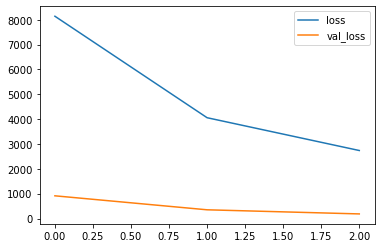

In [48]:
### 시각화
import matplotlib.pyplot as plt
plt.plot(result.epoch, result.history['loss'], label='loss')
# plt.plot(result.epoch, result.history['accuracy'], label='accuracy')
plt.plot(result.epoch, result.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [49]:
# 하나는 훈련 데이터에 대한 것, 하나는 검증 데이터에 대한 것
# -> 범례넣고 비교해보면 

# 각 나타내는 loss나 accuracy 등 뭐가 높은게 더 좋은지 인지한 상태에서 비교
# epoch의 값을 

### [2-4] 평가
---
- evaluate() 메서드
    - 파라미터 : test_data, test_target
    - 반환값 : loss, compile()의 metrics에서 설정한 항목값

- History 반환값
  - loss, accuracy에서의 성능 지표값

In [50]:
eRet = model.evaluate(X_test, y_test)
# loss value & metrics values 가 반환됨

eRet
# loss값, accuracy값

4/4 [==============================] - 0s 667us/step - loss: 184.7586 - accuracy: 0.0000e+00


[184.75857543945312, 0.0]

### [ 2-5 ] 예측
---
- predict()

In [51]:
# 훈련/검증/테스트에 쓰이지 않는 새로운 data를 입력해서 predict()로 예측값을 구하도록
model.predict(X_train[:1])

1/1 [==============================] - 0s 59ms/step


array([[31.525204]], dtype=float32)